# Sequence Bucketing

Instead of clustering directly, we start by pre bucketing using a SAX like algorithm.
First we compress each sequence to `n` symbols and then quantize using k-means.

In [1]:
import yaml
import sys
import os 
import tensorflow as tf
sys.path.append('..')
import pickle
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from tensorflow.keras.models import *

import imp
import ml_pipeline
imp.reload(ml_pipeline)

<module 'ml_pipeline' from '../ml_pipeline/__init__.py'>

In [2]:
from ml_pipeline.audio import *
from ml_pipeline.dtw import * 
from ml_pipeline.sequence_hashing import *
from ml_pipeline.structured import * 
from ml_pipeline.audio_collection import * 

In [ ]:
for filename in tf.io.gfile.listdir(inp):
    if filename.endswith('.ogg') or filename.endswith('.wav'):
        name = filename.replace(".wav", "")
        name = name.replace(".ogg", "")            
        in_path  = "{}/{}".format(inp, filename)
        out_path = "{}/embedding_{}.csv".format(out, name)
        print("\t {}".format(in_path))
        if not os.path.isfile(out_path):
            inducer = TypeExtraction.from_audiofile(in_path, embedder)
            inducer.save(out_path, append=True)

In [ ]:
re          = RegionExtractors(0)
overlapping = []
for file in tf.io.gfile.listdir('../models/v2_lstm_v8/'):        
    if file.startswith("embedding") and file.endswith(".csv"):
        path = "{}/{}".format('../models/v2_lstm_v8/', file)
        print("\tReading {}".format(path))
        header                = ["filename", "start", "stop", "type", "embedding"]
        df                    = pd.read_csv(path, sep="\t", header = None, names=header)
        signals               = df[df['type'] >= 1]
        signals['embedding']  = df['embedding'].apply(
            lambda x: np.array([float(i) for i in x.split(",")]))
        annotated             = [(row['start'], row['stop'], row['filename'], row['embedding'])
                                 for _ , row in signals.iterrows()]
        overlapping += groupBy(annotated, re.overlap)    

In [ ]:
pickle.dump(overlapping, open('overlapping.pkl', 'wb'))

## Filtering size 

In [3]:
min_th = 4
max_th = 250
overlapping = [x for x in pickle.load(open('overlapping.pkl', 'rb')) if len(x[3]) > min_th and len(x[3]) < max_th]
sequences = [np.stack(s) for _, _, _, s in overlapping]
print(len(sequences), len(overlapping))

20682 20682


## Bucket Result

In [4]:
assignments = similarity_bucketing(sequences, 4, 5)
clusters = max(assignments) + 1
print(clusters)

608


In [5]:
counts = np.zeros(clusters)
for i in assignments:
    counts[i] += 1

Percentile 5:  2.0
Percentile 10: 3.0
Percentile 50: 13.0
Percentile 90: 80.30000000000007
Percentile 95: 131.29999999999995


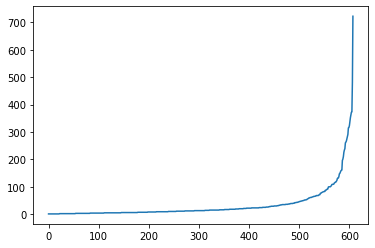

In [6]:
print("Percentile 5:  {}".format(np.percentile(counts, 5)))
print("Percentile 10: {}".format(np.percentile(counts, 10)))
print("Percentile 50: {}".format(np.percentile(counts, 50)))
print("Percentile 90: {}".format(np.percentile(counts, 90)))
print("Percentile 95: {}".format(np.percentile(counts, 95)))

plt.plot(sorted(counts))
plt.show()

In [7]:
by_assignment = {}
for o, s in zip(overlapping, assignments):
    if s not in by_assignment:
        by_assignment[s] = []
    by_assignment[s].append(o)

## Clustering In Each Bucket

+ Make this faster using all processors
+ https://wltrimbl.github.io/2014-06-10-spelman/intermediate/python/04-multiprocessing.html

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import multiprocessing as mp

def process(assignment, overlapping, max_dist = 1.0):
    n = len(overlapping)
    if n > 1:
        max_len = int(max([len(e) for _, _, _, e in overlapping]) + 1)
        dtw = DTW(max_len)
        dist = np.zeros((n, n))
        for i, (start_x, stop_x, f_x, embedding_x) in enumerate(overlapping):
            for j, (start_y, stop_y, f_y, embedding_y) in enumerate(overlapping):
                if i < j:
                    x = np.array([embedding_x]).reshape(len(embedding_x), 256)
                    y = np.array([embedding_y]).reshape(len(embedding_y), 256)
                    d, _       = dtw.align(x, y) 
                    dist[i, j] = d / (len(x) * len(y))
                    dist[j, i] = d / (len(x) * len(y))
        print("\t {} {} {} {} {} {} ".format(assignment, n, np.percentile(dist.flatten(), 5), np.percentile(dist.flatten(), 95), np.mean(dist), np.std(dist)))
        agg = AgglomerativeClustering(n_clusters = None, 
                                      distance_threshold = max_dist, linkage = 'average', affinity='precomputed')
        clustering = agg.fit_predict(dist)
        return clustering, overlapping
    return [], []

pool = mp.Pool(processes=10)
results = [pool.apply_async(process, args=(assignment, overlapping, 1.0)) for assignment, overlapping in by_assignment.items()]
outputs = [p.get() for p in results]

with open('clustering.csv', "w") as fp:
    cur = 0
    for clustering, overlapping in outputs:
        if len(clustering) > 0:
            for c, (start, stop, f, _) in zip(clustering, overlapping):
                fp.write("{},{},{},{}\n".format(start, stop, f, c + cur))
            for c in range(len(set(clustering))):
                cur += 1


In [3]:
df = pd.read_csv('clustering.csv', names=['start', 'stop', 'file', 'clusters'], header = None)

Clusters: 16447


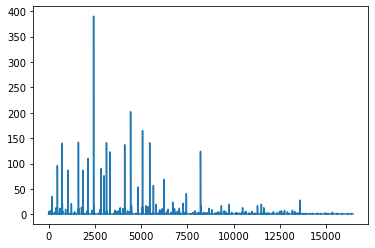

In [4]:
grouped_by_filename = {}
# instance id
clusters = []
for i, row in df.iterrows():
    start = row[0]
    stop = row[1]
    f = row[2]
    c = row[3]
    
    if f not in grouped_by_filename:
        grouped_by_filename[f] = []
    grouped_by_filename[f].append((start, stop, c, i))
    clusters.append(c)
    
k = max(clusters) + 1
instances_clusters = np.zeros(k)
for c in clusters:
    instances_clusters[c] += 1
    
print("Clusters: {}".format(k))
plt.plot(instances_clusters)
plt.show()

In [5]:
import multiprocessing as mp

out = "../models/v2_lstm_v8"

def write_audio(cluster_id, instances_clusters, grouped_by_filename, min_support):
    if instances_clusters[cluster_id] > min_support:
        print("Audio result for cluster: {} {}".format(cluster_id, instances_clusters[cluster_id]))
        audio_bank = AudioSnippetCollection("{}/seq_cluster_{}.wav".format(out, cluster_id))
        for f, regions in grouped_by_filename.items():
            snippets        = [(start, stop) for start, stop, _, _ in regions]
            cluster_snippet = [c for _, _, c,_ in regions] 
            for audio_snippet, c in zip(audio_regions(f, snippets), cluster_snippet):
                if c == cluster_id:
                    audio_bank.write(audio_snippet)
        audio_bank.close()
        print("Done: {}".format(cluster_id))
        
pool = mp.Pool(processes=10)
results = [pool.apply_async(write_audio, args=(cluster_id, instances_clusters, grouped_by_filename, 10)) for cluster_id in range(0, k)]
outputs = [p.get() for p in results]

Audio result for cluster: 177 22.0
Audio result for cluster: 179 35.0
Audio result for cluster: 408 13.0
Audio result for cluster: 475 11.0
Audio result for cluster: 477 96.0
Audio result for cluster: 614 12.0
Audio result for cluster: 736 140.0
Audio result for cluster: 737 11.0
Audio result for cluster: 746 22.0
Audio result for cluster: 1041 13.0
Audio result for cluster: 1042 87.0
Audio result for cluster: 1233 21.0
Audio result for cluster: 1614 142.0
Audio result for cluster: 1624 12.0
Audio result for cluster: 1781 14.0
Audio result for cluster: 1863 87.0
Audio result for cluster: 2131 110.0
Audio result for cluster: 2435 390.0
Audio result for cluster: 2437 12.0
Audio result for cluster: 2444 19.0


NameError: name 'println' is not defined

Audio result for cluster: 2842 90.0
Audio result for cluster: 2997 76.0
Audio result for cluster: 3131 141.0
Audio result for cluster: 3135 15.0
Audio result for cluster: 3312 123.0
Audio result for cluster: 3316 11.0
Audio result for cluster: 3872 13.0
Audio result for cluster: 4006 11.0
Audio result for cluster: 4100 12.0
Audio result for cluster: 4114 137.0
Audio result for cluster: 4434 202.0
Audio result for cluster: 4461 12.0
Audio result for cluster: 4482 17.0
Audio result for cluster: 4843 54.0
Audio result for cluster: 5072 15.0
Audio result for cluster: 5079 165.0
Audio result for cluster: 5274 17.0
Audio result for cluster: 5374 15.0
Audio result for cluster: 5459 15.0
Audio result for cluster: 5466 141.0
Audio result for cluster: 5666 57.0
Audio result for cluster: 5665 18.0
Audio result for cluster: 5818 20.0
Audio result for cluster: 6140 11.0
Audio result for cluster: 6225 69.0
Audio result for cluster: 6709 24.0
Audio result for cluster: 6808 11.0
Audio result for clust

In [ ]:
for cluster_id in range(0, k):
    for f, regions in grouped_by_filename.items():
        filename = f.split(".")[0].split("/")[-1]
        log_path = "{}/seq_clustering_log_{}.csv".format(out, filename)
        #instance id
        with open(log_path, "a+") as fp:
            for start, stop, c, i in regions:
                if c == cluster_id:
                    fp.write("{},{},{},{},{}\n".format(start, stop, f, c, i))                        